In [2]:
import base64
import bz2
import gzip
import io
import json
import os
from threading import Thread
import zlib

import cbor2
from faker import Faker
import numpy as np
import pandas as pd
import requests as rq
import seaborn as sns

from py_dtn7 import DTNWSClient

sns.set_theme(context="paper", style="whitegrid", palette="muted")

Old way of generating article content with different text lengths, now we use `faker`.

In [3]:
articles_paths = {"long": "articles/long_text",
                  "med": "articles/med_text", 
                  "short": "articles/short_text"}
articles = dict()
for k, path_string in articles_paths.items():
    with open(path_string, "r") as fh:
        articles[k] = fh.readlines()

article_length = "short"

Define callback and a buffer to store all messages that are returned from the WS client

In [5]:
ws_msg_buffer = []
def on_msg(ws_data):
    ws_msg_buffer.append(ws_data)

c = DTNWSClient(callback=on_msg)
Thread(target=c.start_client, daemon=True).start()

Define all required data for article transfer:

In [6]:
node_id = "florentin"

email_id = "t.e.schmitt"
email_domain = "posteo.de"
email_address = f"{email_id}@{email_domain}"

group_name = "monntpy.eval"

subject = "Corrupti commodi consequuntur fugiat corporis atque eaque"
message_id = references = f"<714491769820-0@{node_id}-mail-{email_domain}-{email_id}.dtn>"


# body = "".join(articles[article_length])

dtn_sender = f"dtn://{node_id}/mail/{email_domain}/{email_id}"
dtn_receiver = f"dtn://{group_name}/~news"
dtn_lifetime = 5

url = "http://localhost:3000"

fake = Faker("de_DE")
Faker.seed(0)

# from here: https://usenetarchives.com/view.php?id=comp.sys.ibm.pc.hardware&mid=PDEwNDE0QGh5ZHJhLkhlbHNpbmtpLkZJPg
linus = """I've got this new fine computer (386,33MHz etc) but am experiencing some
trouble with my SVGA-card/monitor. The card I have is a VG-2000 by DFI
with 512kB video ram, supposed to be able to do almost anything (well
1024x768 16 colours anyway). The problem is - it doesn't. I've got th
drivers and manual and they tell me less than zero - except that the
really high resolution modes don't work. I am able to see all normal VGA
modes with the addition of 800x600 (16 c), so I'm still pleased with my
card. What bugs me is that none of these modes really need 512kB, so
I've bought that for nothing.
My guess so far has been a problem with my monitor - it's supposed to be
able to display 1024x768, but it's INTERLACED. Is that a problem? If so
is it "terminal", or can one tell the card to use interlaced mode?
The weird thing is that I can see 640x480,16c (obviously as it's normal
VGA), but I'm unable to get 640x480,256c to work even though this as I
would understand it has the same frequency (flame me if I'm wrong).
PS. the monitor is a GoldStar 1460 Plus, and the card has a trident TVGA
(don't know the code, will check if necessary) controller.
Please reply by mail to 't*******s@c*.********i.fi' (or follow-up if you
would like to use "tens of thousands of dollars" :-)
advTHANKSance
t*******s@c*.********i.fi t*******s@c*.********i.fi"""

tb_headers = """From - Fri, 07 Oct 2022 13:03:43 GMT
X-Mozilla-Status: 0001
X-Mozilla-Status2: 00800000
Date: Fri, 7 Oct 2022 13:03:43 +0000
MIME-Version: 1.0
User-Agent: Mozilla/5.0 (X11; Linux x86_64; rv:102.0) Gecko/20100101
 Thunderbird/102.2.2
Newsgroups: monntpy.offtopic
Content-Language: en-US
From: "J. Doe" <j.doe@monntpy.org>
Subject: This is the subject
Content-Type: text/plain; charset=UTF-8; format=flowed
Content-Transfer-Encoding: 7bit"""

In [7]:
def get_latest_bundle():
    bid_list_resp = rq.get(f"{url}/status/bundles")
    bid_list = sorted(json.loads(bid_list_resp.content))
    return rq.get(f"{url}/download?{bid_list[-1]}").content

In [8]:
stats = []
num_runs = 20

for num_paragraphs in range (1,21):
    for f in range(num_runs):

        body = '\n\n'.join([fake.paragraph(nb_sentences=15, variable_nb_sentences=True) for _ in range(num_paragraphs)])
        len_body = len(body)
        
        dtn_args: dict = {
            # map NNTP to BP7 MAPPING
            "source": dtn_sender,
            "destination": dtn_receiver,
            "delivery_notification": False,
            "lifetime": dtn_lifetime,
        }
        dtn_payload: dict = {
            "subject": subject,
            "body": body,
            "references": references,
        }


        nntp_payload = f"""From: {email_address}
Newsgroups: {group_name}
Date: Mon, 22 Aug 2022 13:56:09 UTC
Subject: {subject}
Message-ID: {message_id}
References: {references}

{body}
."""
        
        # size_nntp.append(len(nntp_payload))
        stats.append({"type": "NNTP", "size": len(nntp_payload.encode()), "num_par": num_paragraphs, "len_body": len_body})
        
        # send payload uncompressed
        c.send_data(**dtn_args, data=cbor2.dumps(dtn_payload))
        stats.append({"type": "BP7_text", "size": len(get_latest_bundle()), "num_par": num_paragraphs, "len_body": len_body})
        
        # send payload bz2 compressed
        dtn_payload["body"] = bz2.compress(body.encode("utf-8"))
        c.send_data(**dtn_args, data=cbor2.dumps(dtn_payload))
        stats.append({"type": "BP7_bz2", "size": len(get_latest_bundle()), "num_par": num_paragraphs, "len_body": len_body})
        
        # send payload zlib compressed
        dtn_payload["body"] = zlib.compress(body.encode("utf-8"))
        c.send_data(**dtn_args, data=cbor2.dumps(dtn_payload))
        stats.append({"type": "BP7_zlib", "size": len(get_latest_bundle()), "num_par": num_paragraphs, "len_body": len_body})
        
        # send payload gzip compressed
        dtn_payload["body"] = gzip.compress(body.encode("utf-8"))
        c.send_data(**dtn_args, data=cbor2.dumps(dtn_payload))
        stats.append({"type": "BP7_gz", "size": len(get_latest_bundle()), "num_par": num_paragraphs, "len_body": len_body})


df = pd.DataFrame(stats)

In [9]:
bins=[0, 1999, 3999, 5999, 7999, 9999, np.inf]
labels = ["<2000", "2000-3999", "4000-5999", "6000-7999", "8000-9999", ">=10000"]
df["bin"] = pd.cut(df["len_body"], bins=bins, labels=labels)

In [14]:
wide_df = pd.pivot_table(df, index=["num_par", "len_body", "bin"], columns=["type"], values=["size"])["size"].reset_index().sort_values(["len_body"])
wide_df["comp_bz2"] = wide_df["BP7_bz2"] / wide_df["NNTP"]
wide_df["comp_zlib"] = wide_df["BP7_zlib"] / wide_df["NNTP"]
wide_df["comp_gz"] = wide_df["BP7_gz"] / wide_df["NNTP"]
wide_df = wide_df[["bin", "comp_bz2", "comp_zlib", "comp_gz"]]
wide_df

type,bin,comp_bz2,comp_zlib,comp_gz
0,<2000,0.860884,0.815057,0.834697
1,<2000,0.852941,0.812693,0.832817
2,<2000,0.836923,0.793846,0.812308
3,<2000,0.813514,0.772973,0.789189
4,<2000,0.811170,0.775266,0.791223
...,...,...,...,...
395,>=10000,0.378193,0.432482,0.433397
396,>=10000,0.377239,0.432998,0.433912
397,>=10000,0.375217,0.430910,0.432099
398,>=10000,0.375939,0.431713,0.432875


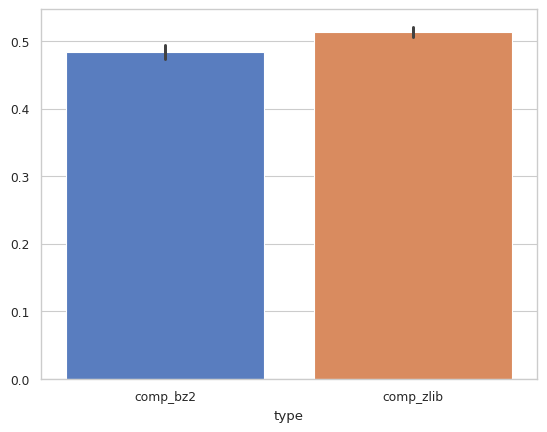

In [13]:
g = sns.barplot(data=wide_df[["comp_bz2", "comp_zlib"]])

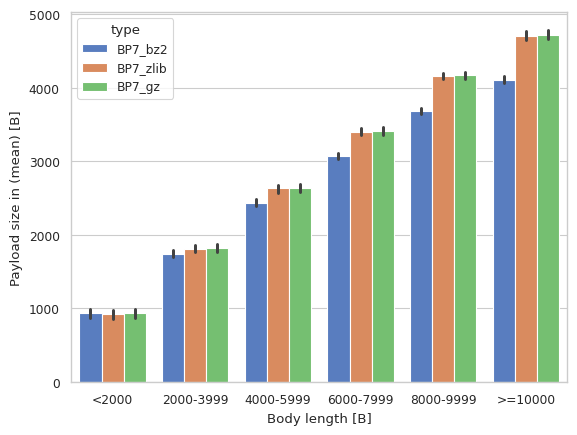

In [13]:
g = sns.barplot(data=df[~df["type"].isin(["NNTP", "BP7_text"])], hue="type", x="bin", y="size")
g.set_xlabel("Body length [B]")
g.set_ylabel("Payload size in (mean) [B]")
None

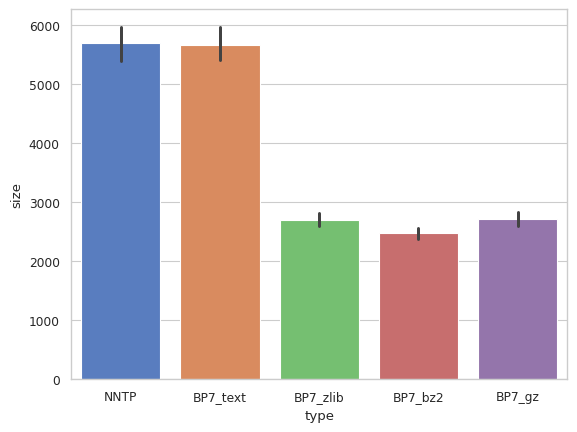

In [270]:
g = sns.barplot(data=df, x="type", y="size")

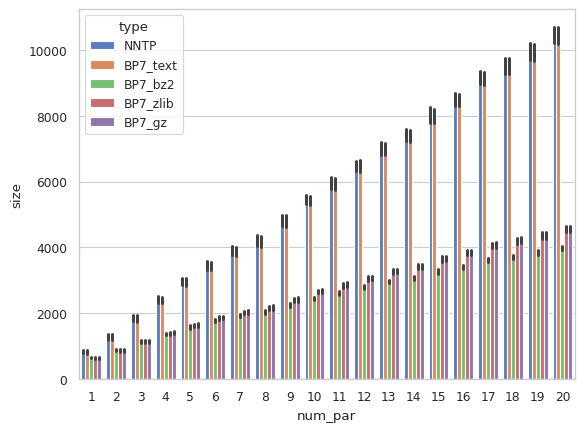

In [16]:
g = sns.barplot(data=df, x="num_par", y="size", hue="type")

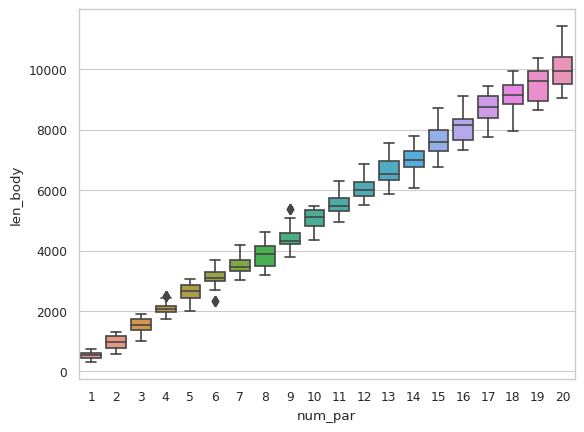

In [17]:
g = sns.boxplot(data=df, x="num_par", y="len_body")

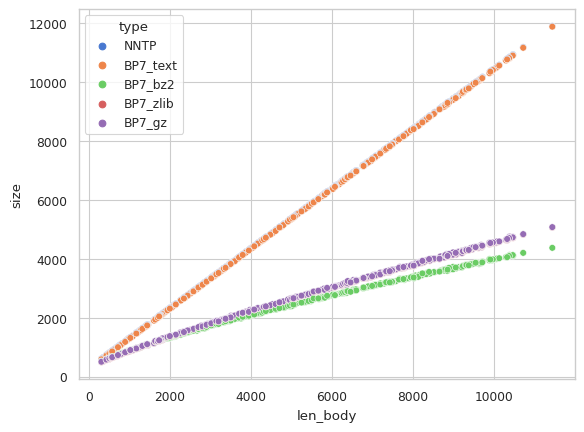

In [18]:
g = sns.scatterplot(data=df, x="len_body", y="size", hue="type")

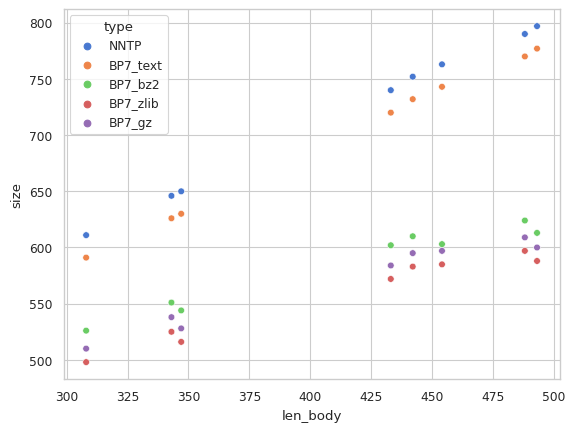

error=WebSocketConnectionClosedException('Connection to remote host was lost.')
Connection closed


In [19]:
g = sns.scatterplot(data=df[df["len_body"] < 500], x="len_body", y="size", hue="type")

In [206]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [61]:
latest_bundle_from_dtnd

b'\x9f\x88\x07\x04\x00\x82\x01t//monntpy.eval/~news\x82\x01x&//florentin/mail/posteo.de/t.e.schmitt\x82\x01x&//florentin/mail/posteo.de/t.e.schmitt\x82\x1b\x00\x00\x00\xa6\xb1\x1e\xe9\xc4\x00\x19\x8c\xa0\x85\x01\x01\x00\x00Y\x01Y\xa3gsubjectx9Corrupti commodi consequuntur fugiat corporis atque eaquedbodyx\xc8123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789\n123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789\njreferencesx9<714491769820-0@florentin-mail-posteo.de-t.e.schmitt.dtn>\xff'

In [62]:
len(cbor2.loads(latest_bundle_from_dtnd)[1][4])

345

In [60]:
json.dumps(dtn_payload)

'{"subject": "Corrupti commodi consequuntur fugiat corporis atque eaque", "body": "123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789\\n123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789\\n", "references": "<714491769820-0@florentin-mail-posteo.de-t.e.schmitt.dtn>"}'

### Zlib experiments

In [5]:
import base64
import zlib
# b64_payload = base64.b64encode(nntp_payload.encode("utf-8"))
string_payload_zipped = zlib.compress(nntp_payload.encode("utf-8"))
b64_encoded_zip = base64.b64encode(string_payload_zipped)
print(f"Length of zipped text payload: {len(string_payload_zipped)}, length of b64 encoded zip: {len(b64_encoded_zip)}")

NameError: name 'nntp_payload' is not defined

In [8]:
test_string = "" # "🥳1234🔭567890🪛"
zlib_len = len(zlib.compress(test_string.encode("utf-8")))
cbor_len = len(cbor2.dumps(zlib.compress(test_string.encode("utf-8"))))
print(f"String length: {len(test_string)}, Zip length: {zlib_len}, Overhead: {zlib_len - len(test_string)}, CBOR Length: {cbor_len}")

String length: 0, Zip length: 8, Overhead: 8, CBOR Length: 9


In [9]:
import bz2

bz2_len = len(bz2.compress(test_string.encode("utf-8")))
cbor_len = len(cbor2.dumps(bz2.compress(test_string.encode("utf-8"))))
print(f"String length: {len(test_string)}, Zip length: {bz2_len}, Overhead: {bz2_len - len(test_string)}, CBOR Length: {cbor_len}")

String length: 0, Zip length: 14, Overhead: 14, CBOR Length: 15


In [14]:
fake = Faker("de_DE")
Faker.seed(0)

In [55]:
for _ in range(3):
    print(fake.paragraph(nb_sentences=8, variable_nb_sentences=True))
    print()

Weg liegen Katze Mädchen rechnen ich. Gott Garten sicher warm. Heißen ziehen Finger. Tür Arbeit ging wir müde gern Vogel. Ball Wald wenn leicht. Schlecht Lehrerin Hand aus dauern Boden glücklich ihn. Katze was noch. Krank Kopf halbe oben sprechen schauen. Spiel mein finden voll nie. Zum fest später gefährlich nur nur.

Stelle Bauer was Schluss sieben stehen lange. Jung Straße packen erklären Monat. Erst Bein die. Endlich spät wohnen.

Schnee Affe kommen holen später sonst kalt. Laufen endlich Eltern antworten. Vater traurig hoch hier noch Mensch. Geld wohl ihn freuen reich treffen. Uns Seite gut packen sprechen las. Mögen Onkel halbe Wetter lesen fiel. Fast Finger wollen fliegen Junge fährt. Feuer nun erklären. Vogel legen wohl Ball rennen Küche Auge. Bringen unten müssen Meer dich mögen Rad sonst.



In [95]:
import gzip, bz2, zlib
from timeit import Timer

from faker import Faker
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

fake = Faker("de_DE")
Faker.seed(0)
cm = 1 / 2.54

In [96]:
num_samples = 10
num_runs = 1000
ms = ["zlib", "gzip", "bz2"]
res = {"text_len": [], "text_size": [], "compr_ratio": [], "method": [], "time": []}
par_enc = bytes()

for sen in range(1,50):
    for _ in range(num_samples):
        par = fake.paragraph(nb_sentences=sen, variable_nb_sentences=True)
        len_par = len(par)
        par_enc = par.encode()
        len_par_enc = len(par_enc)
        for m in ms:
            s = zlib.compress(par_enc) if m == "zlib" else (gzip.compress(par_enc) if m == "gzip" else bz2.compress(par_enc))
            t = Timer(stmt=f"{m}.compress(par_enc)", setup=f"import {m}", globals=globals()).timeit(number=num_runs)
            res["text_len"].append(len_par)
            res["text_size"].append(len_par_enc)
            res["compr_ratio"].append(len(s) / len_par_enc)
            res["method"].append(m)
            res["time"].append(t)
            

In [97]:
df = pd.DataFrame.from_dict(res)

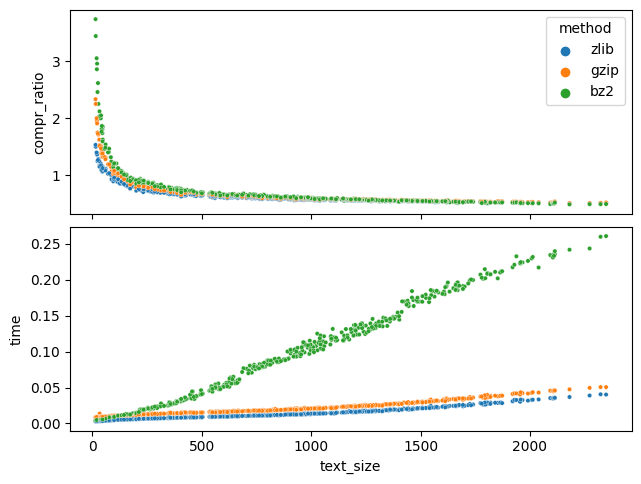

In [119]:
fig, ax = plt.subplots(2, 1, figsize=(16*cm, 2*6*cm), constrained_layout=True, sharex=True)
g1 = sns.scatterplot(data=df, hue="method", x="text_size", y="compr_ratio", ax=ax[0], s=10)
g2 = sns.scatterplot(data=df, hue="method", x="text_size", y="time", ax=ax[1], s=10)
g2.get_legend().remove()
# _ = g1.set(ylim=(.4, 1.5))

In [132]:
fig.savefig("figures/ch5_compr_eval.pdf")

In [131]:
df[(df["method"] == "zlib") & (df["text_size"] < 100)].sort_values(["compr_ratio"])

,text_len,text_size,compr_ratio,method,time
102,96,96,0.895833,zlib,0.004794
60,88,88,0.931818,zlib,0.004970
123,97,98,0.938776,zlib,0.004768
69,86,87,1.000000,zlib,0.004277
87,84,85,1.011765,zlib,0.004829
33,75,76,1.026316,zlib,0.004308
78,69,72,1.027778,zlib,0.004148
90,75,77,1.038961,zlib,0.004187
3,45,46,1.065217,zlib,0.003864
93,60,60,1.083333,zlib,0.003769
